In [4]:
import os,sys
import csv
import copy
import math
import collections
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from clawpack import pyclaw
from clawpack import riemann
from IPython.display import HTML
import numpy as np
from scipy.integrate import simps, trapz
from scipy.interpolate import interp1d
from scipy import signal
sys.path.append("/pymorph")

import logging
logger = logging.getLogger('pyclaw')
logger.setLevel(logging.CRITICAL)

import morph_geom_lib as mgl
import models.parameterized_morph_models as parameter_models
import models.parameterized_models.parameterized_exner_models as exner_models
import schemes.avalanche_scheme 
import utils.post_processing as post



from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

from IPython.display import display, Math, Latex
from matplotlib import animation, rc

import schemes.weno as weno
import sediment_transport.sed_trans as sedtrans
from schemes.avalanche_scheme import avalanche_model, get_slope
from models.shallow_water_solver import shallow_water_solver

rc('animation', html='html5')
%matplotlib widget
%load_ext autoreload
%autoreload 2
%matplotlib inline
plt.style.use(['default'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


dx: 0.8682235195996664 cm
nx 1200


Text(0, 0.5, 'z (m)')

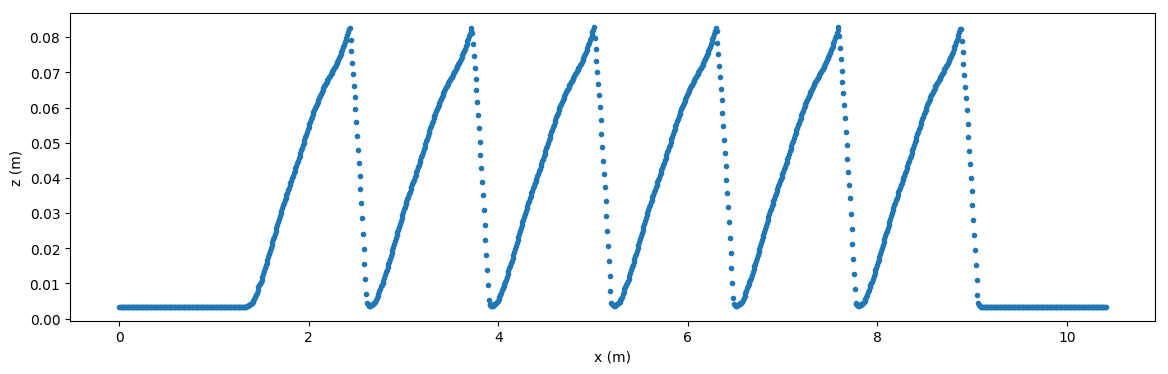

In [5]:
filepath = '../Paper_3/dune_profile_dune5_rep_runway.txt'

def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False
    


def readFile(filepath, resolution_cells = 800):
    xs = []
    zs = []
    with open(filepath) as f:
        for line in f:
            values = line.split(',')
            if is_number(values[0]) and is_number(values[1]):
                x = float(values[0])
                z = float(values[1])
                xs.append(x)
                zs.append(z)
                
    xs = np.array(xs)
    zs = np.array(zs)
    
    #--------------------------------
    # Increase the resolution on the grid
    #--------------------------------
    xmax = xs.max()
    nx = len(xs)
    f = interp1d(xs, zs)
    
    xnew = np.linspace(0., xmax, num=resolution_cells)
    znew = f(xnew)
    return xnew, znew

x0,z0 = readFile(filepath, resolution_cells = 1200)

dx = x0[1] - x0[0]

print('dx: {0} cm'.format(dx*100.))
print('nx {0}'.format(len(x0)))

fig = plt.figure(figsize=(14, 4))
plt.plot(x0,z0, '.')
plt.xlabel('x (m)')
plt.ylabel('z (m)')

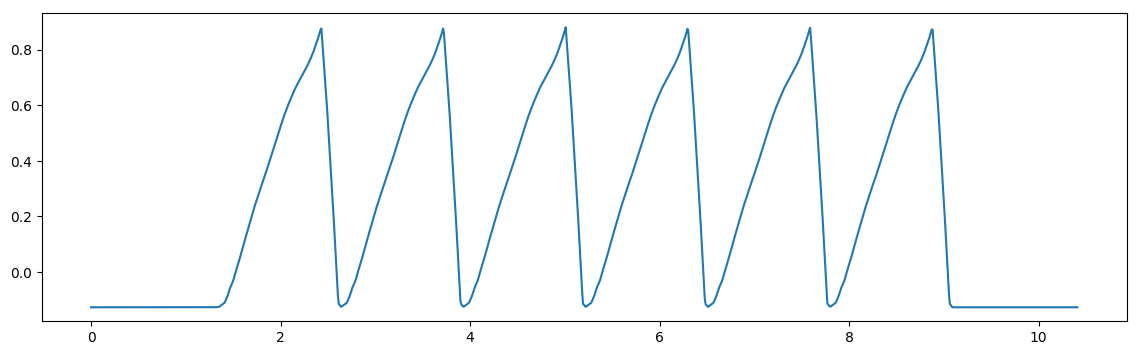

In [6]:

zn = [(zs - 0.0134)/0.079 for zs in z0]
fig = plt.figure(figsize=(14, 4))
plt.plot(x0, zn)

## 32 cm Flow Case

This is the basic case. The z was transformed to a qsb to achieve the desired migration rate. The migration rate was extracted from the graph of profiles (guess I could have done it more accurately from the actual data)? The measured migration rate was 0.95 m/hr. The model uses the following:  qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]



In [7]:
#--------------------------------
# Set up the bed properties
#--------------------------------
D50 = 0.001
repose_angle = 30.
rho_particle = 2650.
nP = 0.4

#--------------------------------
# Set up the Boundary conditions
#--------------------------------
# 32 cm Case 
Qc132 = 0.0455
Qc120 = 0.020
B = 0.76
Qtotal32 = Qc132 * 3.
Qtotal20 = Qc120 * 3.
q32cm = Qtotal32 / B
q20cm = Qtotal20 / B

sOut32 = 0.357
sOut20 = 0.237

#--------------------------------
# Set up the Flow Proerties
#--------------------------------
mannings_n = 0.024
bed_slope = 1.26/1000.
ks=0.0033

 Starting simulation....
Number of time steps: 30.0 mins
Grid dx = 0.008682235195996663
Grid nx = 1200
Initializing hydrodynamic model...
Completed the intialization of the model
D50:    0.001
Rho Particle:    2650.0
Angle Repose Degrees:    30.0
Time step: 1.0 mins - uavg: 0.0 - Elevation 0.032884586391434635
Courant number: max 0.30859851570828584, mean0.23454337357414565
Time step: 2.0 mins - uavg: 0.0 - Elevation 0.03288458639143056
Courant number: max 0.30859851570829877, mean0.23607809739996233
Time step: 3.0 mins - uavg: 0.0 - Elevation 0.032884586391433226
Courant number: max 0.30859851570829083, mean0.2367129117822257
Time step: 4.0 mins - uavg: 0.0 - Elevation 0.03288458639143124
Courant number: max 0.30859851570829683, mean0.23742707969427007
Time step: 5.0 mins - uavg: 0.0 - Elevation 0.03288458639143263
Courant number: max 0.3085985157083496, mean0.23735553452995026
Time step: 6.0 mins - uavg: 0.0 - Elevation 0.03288458639143952
Courant number: max 0.3085985157082906, mean

Text(0, 0.5, 'z (m)')

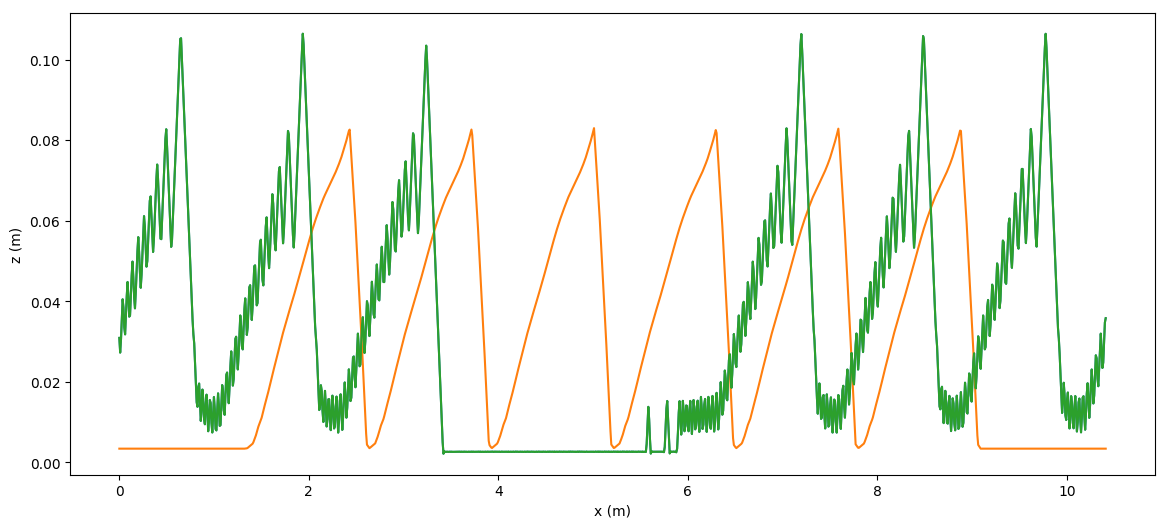

In [12]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 300*60 #10*300       # Runtime in seconds
dt = 10                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60

run_name = 'dune_5_Parameterized_{0}_v01'.format('32cm')

model = parameter_models.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = exner_models.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)

#---------------------------------
# Specific properties for the case
#----------------------------------
qsbmax = 0.0000127
delta = 0.079
zoffset = 0.0034
qsbmodel = parameter_models.EquilibriumBedloadModel(qsbmax, delta, zoffset)
model.set_bedload_model(qsbmodel)

xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [9]:
from scipy.signal import savgol_filter
heights = [post.calculate_wave_height(verts[t,:,1],dx) for t in range((verts.shape[0]))]
savgol_filter(heights,3,2)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
run_name = 'dune_5_Parameterized_v01'.format('32m','357mm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

In [ ]:
HTML(post.make_animation(verts).to_html5_video())



In [ ]:
peaks_0, _ = post.find_peaks(z0, height = z0.mean()*0.8, distance = int(1.2/dx))
peaks_0

In [ ]:
peaks_final, _ = post.find_peaks(zc, height = zc.mean()*0.8, distance = int(1.2/dx))
peaks_final

In [ ]:
for i in range(len(peaks_0)):
    print( dx * (peaks_final[i] - peaks_0[i])/(0.5))

In [ ]:
qbedload_32 = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z0]
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, qbedload_32)

phases = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)



In [ ]:
phases = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)
fig = plt.figure(figsize=(14, 6))
plt.plot(x0, phases)

## Transition

qbedload = np.zeros(len(x))
        
        a = 0.00002
        b = 2
        c = 1.
        d = -0.15
        
        # So the dune height is 7.9 cm - make the q - 0.00001 at the max height 
        # This will essentially calibrate the model
 
        # For 32 cm case
        qbedload = [((zs - 0.0134)/0.079 * 0.0000127) for zs in z]
        
        
        ''' t = self._time / 60.
        for i in range(self._nx):            
            znorm = (z[i])/0.079
            
            qbedload[i] = a*znorm**(c*math.exp(d*(t))+ 1)'''  

In [ ]:
a = 0.0000127
b = 2
c = 1.
d = -0.02

fig = plt.figure(figsize=(23, 3))
for t in range(0, 100, 25):
    qbedload = [a*(z/0.036)**(c*math.exp(d*(t))+ 1) for z in z0]
    plt.plot(x0, qbedload, label='t={0}'.format(t))
    
plt.plot(x0, qbedload_32, label='Orig')
plt.legend()



In [ ]:
a = 0.0000127
b = 2
c = 1.
d = -0.02

fig,ax1 = plt.subplots(figsize=(23, 3))
#for t in range(0, 102, 25):
t = 100
qbedload = [a*(z/0.036)**(c*math.exp(d*(t))+ 1) for z in z0]
phases = weno.get_Phase_Speeds(qbedload, z0, 0.4)
plt.plot(x0, phases, label='t={0}'.format(t))
    
phases32 = weno.get_Phase_Speeds(qbedload_32, z0, 0.4)
plt.plot(x0, phases32, label='Orig')
plt.legend()

ax2 = ax1.twinx()
ax2.plot(x0, z0)


In [ ]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 30*60     # Runtime in seconds
dt = 1.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 60.*2

run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')

model = parameter_models.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


qsbmodel = parameter_models.NonEquilibriumBedloadModel(qsbmax, delta, zoffset, c, d)
model.set_bedload_model(qsbmodel)

xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [ ]:
run_name = 'dune_5_Parameterized_v01'.format('32m','357mm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

In [ ]:

verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))

post.make_animation(verts)

In [ ]:
#--------------------------------
#  Setup the model run parameters
#--------------------------------
simTime = 60*30    # Runtime in seconds
dt = 1.0                # Time step size (s)
nt = int(simTime/dt)  # Number of time steps
extractionTime = 10

run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')

model = sdmodels.ParameterizedMorphologicalModel()

#--------------------------------
# Set up the geometry
#--------------------------------
xc = x0.copy()
zc = z0.copy()
nx = len(xc)

model.setup_domain(x0, z0, dx)
model.setup_bed_properties( D50, repose_angle=repose_angle, rho_particle = rho_particle, nP = nP)
model.flow_boundary_conditions(q32cm, sOut32)
model.setup_chezy_hydro_model(ks, bed_slope)

#--------------------------------
# Set up the Morphodynamic Proerties
#--------------------------------
#morph_model = sdmodels.EulerWenoModel()
morph_model = sdmodels.TVD2ndWenoModel()
model.setup_morpho_model( morph_model, 
                           useAvalanche = True, 
                           useSmoother = False, 
                           sed_model='bagnold', 
                           useSlopeAdjust = False)


xc, zc, u, q, h, qbedload = model.run(simTime, dt, extractionTime, None)
surf = zc + h



df = model.get_wave_dataframe()
df.to_csv('_output/{0}_waves.csv'.format(run_name))
np.save('_output/{0}_z.npy'.format(run_name),zc)
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)


fig = plt.figure(figsize=(14, 6))
plt.plot(xc,zc)
plt.plot(x0,z0)
plt.plot(xc, surf)

plt.xlabel('x (m)')
plt.ylabel('z (m)')


In [ ]:
run_name = 'dune_5_Parameterized_{0}_v01'.format('20cm')
verts = model._verts
np.save('_output/{0}_verts.npy'.format(run_name, verts),verts)
verts = np.load('_output/{0}_verts.npy'.format(run_name))


dx = x0[1] - x0[0]
post.plot_results(verts, dx, dt, extractionTime)

In [ ]:
plt.plot(xc,zc)

In [ ]:
xc.max(), x0.max()